In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.models import googlenet

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:


print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


0
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU
True


In [41]:
IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=5
CHANNELS=3#rgb
num_classes=14

In [17]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [18]:
current_dir = os.getcwd()

# Path to your dataset folder (relative path)
dataset_folder = os.path.join(current_dir, "PlantDisease")

# Load the dataset
dataset = ImageFolder(root=dataset_folder, transform=transform)
class_names = dataset.classes
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)



In [19]:
len(dataset)

22107

In [21]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [22]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


17685
2210
2212


In [23]:


# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# **ENSEMBLE LEARNING**

In [24]:
# Load pre-trained models
google_net = models.googlenet(pretrained=True).cuda()
res_net = models.resnet18(pretrained=True).cuda()


In [25]:
# Freeze the parameters in both models
for param in google_net.parameters():
    param.requires_grad = False
for param in res_net.parameters():
    param.requires_grad = False

In [26]:
# Modify the output layers to match the number of classes in your dataset
google_net.fc = nn.Linear(google_net.fc.in_features, num_classes)
res_net.fc = nn.Linear(res_net.fc.in_features, num_classes)

In [27]:
class EnsembleModel(nn.Module):
    def __init__(self, google_net, res_net, num_classes):
        super(EnsembleModel, self).__init__()
        self.google_net = google_net
        self.res_net = res_net
        # Modify the output sizes to match the concatenation of features
        self.google_net.fc = nn.Linear(self.google_net.fc.in_features, num_classes).cuda()
        self.res_net.fc = nn.Linear(self.res_net.fc.in_features, num_classes).cuda()
        # Concatenate the features from both models
        self.fc = nn.Linear(self.google_net.fc.out_features + self.res_net.fc.out_features, num_classes).cuda()

    def forward(self, x):
        google_features = self.google_net(x)
        res_features = self.res_net(x)
        assert google_features.size(0) == res_features.size(0), "Batch sizes do not match"
        assert google_features.size(1) == self.google_net.fc.out_features
        assert res_features.size(1) == self.res_net.fc.out_features
        features = torch.cat((google_features, res_features), dim=1)
        return self.fc(features)



In [28]:
# Initialize the ensemble model
ensemble_model = EnsembleModel(google_net, res_net, num_classes)

In [29]:
# Define loss function and optimizer

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)


In [30]:
def calculate_accuracy(loader, ensemble_model):
    ensemble_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = ensemble_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


Epoch 1, Training Accuracy: 98.50%, Validation Accuracy: 98.60%
Epoch 2, Training Accuracy: 98.55%, Validation Accuracy: 98.55%
Epoch 3, Training Accuracy: 98.69%, Validation Accuracy: 98.28%
Epoch 4, Training Accuracy: 98.53%, Validation Accuracy: 98.60%
Epoch 5, Training Accuracy: 98.55%, Validation Accuracy: 98.42%
Epoch 6, Training Accuracy: 98.86%, Validation Accuracy: 98.64%
Epoch 7, Training Accuracy: 98.66%, Validation Accuracy: 98.60%
Epoch 8, Training Accuracy: 98.86%, Validation Accuracy: 98.28%
Epoch 9, Training Accuracy: 98.76%, Validation Accuracy: 98.42%
Epoch 10, Training Accuracy: 98.77%, Validation Accuracy: 98.46%
Epoch 11, Training Accuracy: 99.04%, Validation Accuracy: 98.69%
Epoch 12, Training Accuracy: 99.01%, Validation Accuracy: 98.51%
Epoch 13, Training Accuracy: 98.93%, Validation Accuracy: 98.51%
Epoch 14, Training Accuracy: 98.82%, Validation Accuracy: 98.24%
Epoch 15, Training Accuracy: 98.92%, Validation Accuracy: 98.28%
Epoch 16, Training Accuracy: 99.00

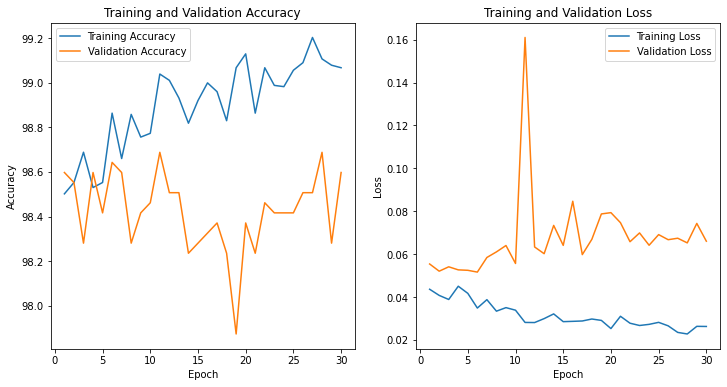

In [34]:


# Initialize lists to store accuracy and loss values
train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    ensemble_model.train()
    total_train_correct = 0
    total_train_samples = 0
    total_train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()
        total_train_loss += loss.item()

    train_accuracy = total_train_correct / total_train_samples * 100
    train_loss = total_train_loss / len(train_loader)

    # Evaluate model on validation set after each epoch
    ensemble_model.eval()
    total_val_correct = 0
    total_val_samples = 0
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to GPU
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = ensemble_model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_val_samples += labels.size(0)
            total_val_correct += (predicted == labels).sum().item()
            total_val_loss += loss.item()

    val_accuracy = total_val_correct / total_val_samples * 100
    val_loss = total_val_loss / len(val_loader)

    # Append accuracy and loss values to lists
    train_acc_values.append(train_accuracy)
    val_acc_values.append(val_accuracy)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)

    print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_acc_values, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_acc_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()





In [35]:
# Evaluate on validation set
val_accuracy = calculate_accuracy(val_loader, ensemble_model)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on test set
test_accuracy = calculate_accuracy(test_loader, ensemble_model)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.9859728506787331
Test Accuracy: 0.9855334538878843


Image to predict:


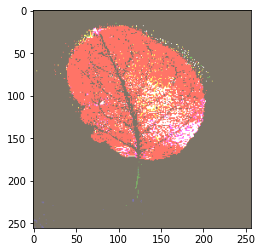

Actual label: Apple___healthy
Predicted label: Apple___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 100.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


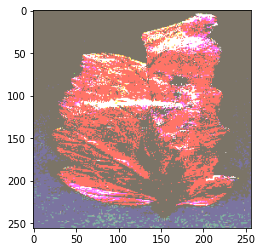

Actual label: Tomato___Bacterial_spot
Predicted label: Tomato___Bacterial_spot
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 100.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


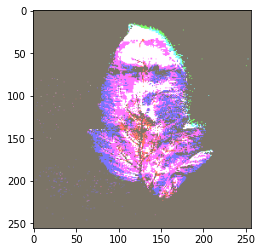

Actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.02%
Tomato___Early_blight: 0.01%
Tomato___Late_blight: 0.38%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 99.59%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


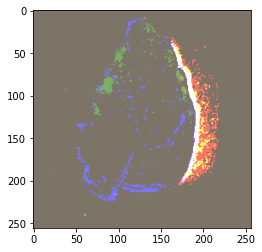

Actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 4.93%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 95.07%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


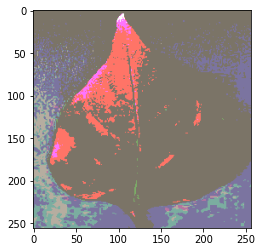

Actual label: Pepper,_bell___healthy
Predicted label: Pepper,_bell___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 100.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


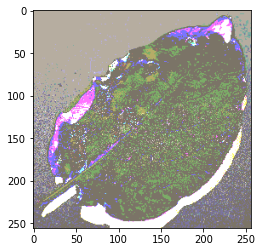

Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 100.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


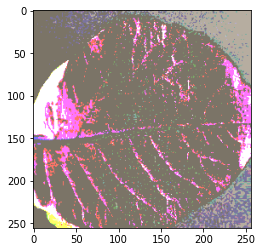

Actual label: Potato___healthy
Predicted label: Potato___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 100.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


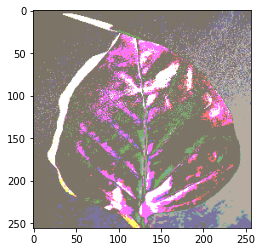

Actual label: Pepper,_bell___healthy
Predicted label: Pepper,_bell___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 100.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


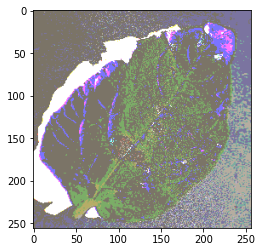

Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 100.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


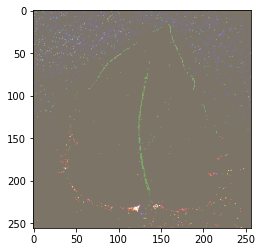

Actual label: Tomato___healthy
Predicted label: Tomato___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 100.00%

Image to predict:


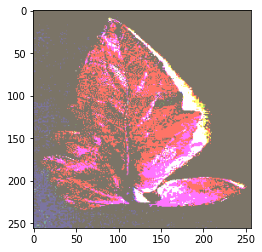

Actual label: Tomato___Bacterial_spot
Predicted label: Tomato___Bacterial_spot
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 95.73%
Tomato___Early_blight: 4.24%
Tomato___Late_blight: 0.01%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.01%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


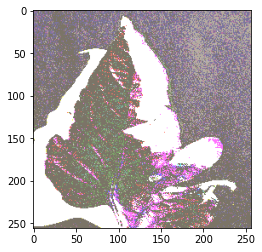

Actual label: Tomato___Early_blight
Predicted label: Tomato___Early_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 99.99%
Tomato___Late_blight: 0.01%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%



In [74]:


def predict_with_confidence(data_loader, ensemble_model, class_names, device):
    ensemble_model.eval()  # Set model to evaluation mode
    ensemble_model.to(device)  # Move model to the correct device
    with torch.no_grad():  # Disable gradient calculation
        images_processed = 0
        for images_batch, labels_batch in data_loader:
            images_batch = images_batch.to(device)  # Move input tensors to the correct device
            labels_batch = labels_batch.to(device)  # Move input tensors to the correct device
            
            
            
            for i in range(len(images_batch)):
                image = images_batch[0].permute(1, 2, 0).numpy()
                image = (image - image.min()) / (image.max() - image.min())
                label = labels_batch[i].item()

                print("Image to predict:")
                image = np.squeeze(image) 
                
                plt.imshow(np.transpose(image, (1, 2, 0)))  # Transpose image from (C, H, W) to (H, W, C)
                plt.show()
                print("Actual label:", class_names[label])

                outputs = ensemble_model(images_batch[i].unsqueeze(0))  # Add batch dimension
                _, predicted = torch.max(outputs, 1)
                confidence = torch.nn.functional.softmax(outputs, dim=1)[0]  # Calculate confidence scores
                predicted_label = predicted.item()
                
                print("Predicted label:", class_names[predicted_label])
                print("Confidence scores:")
                for class_idx, class_name in enumerate(class_names):
                    print(f"{class_name}: {confidence[class_idx].item() * 100:.2f}%")
                print()

                images_processed += 1
                if images_processed >= 12:
                    break
            if images_processed >= 12:
                break

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predict_with_confidence(test_loader, ensemble_model, class_names, device)




# **ALEX NET**

In [31]:
model_alex = alexnet(pretrained=True)

In [32]:
model_alex=model_alex.cuda()

In [33]:
# Replace the final layer with a new fully connected layer for 14 classes
num_ftrs = model_alex.classifier[6].in_features
model_alex.classifier[6] = nn.Linear(num_ftrs, num_classes)

In [34]:
# Define the loss function and optimizer
criterion_alex = nn.CrossEntropyLoss().cuda()
optimizer_alex = torch.optim.SGD(model_alex.parameters(), lr=0.001, momentum=0.9)

In [37]:
def calculate_accuracy(model_alex, loader):
    model_alex.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model_alex(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Epoch 1, Training Accuracy: 99.92%, Training Loss :0.003014%, Validation Accuracy: 99.37%, Validation Loss :0.025838%
Epoch 2, Training Accuracy: 99.99%, Training Loss :0.000813%, Validation Accuracy: 99.50%, Validation Loss :0.022402%
Epoch 3, Training Accuracy: 99.86%, Training Loss :0.004276%, Validation Accuracy: 98.96%, Validation Loss :0.031307%
Epoch 4, Training Accuracy: 99.84%, Training Loss :0.005361%, Validation Accuracy: 99.19%, Validation Loss :0.033886%
Epoch 5, Training Accuracy: 99.80%, Training Loss :0.006296%, Validation Accuracy: 98.69%, Validation Loss :0.035305%


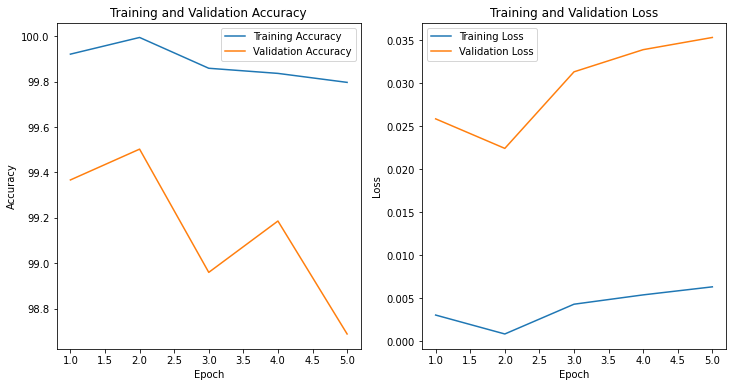

In [42]:
# Initialize lists to store accuracy and loss values
train_acc_values = []
val_acc_values = []
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    model_alex.train()
    total_train_correct = 0
    total_train_samples = 0
    total_train_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move inputs and labels to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer_alex.zero_grad()
        outputs = model_alex(inputs)
        loss = criterion_alex(outputs, labels)
        loss.backward()
        optimizer_alex.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()
        total_train_loss += loss.item()

    train_accuracy = total_train_correct / total_train_samples * 100
    train_loss = total_train_loss / len(train_loader)

    # Evaluate model on validation set after each epoch
    model_alex.eval()
    total_val_correct = 0
    total_val_samples = 0
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to GPU
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model_alex(inputs)
            loss = criterion_alex(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_val_samples += labels.size(0)
            total_val_correct += (predicted == labels).sum().item()
            total_val_loss += loss.item()

    val_accuracy = total_val_correct / total_val_samples * 100
    val_loss = total_val_loss / len(val_loader)

    # Append accuracy and loss values to lists
    train_acc_values.append(train_accuracy)
    val_acc_values.append(val_accuracy)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)

    print(f"Epoch {epoch+1}, Training Accuracy: {train_accuracy:.2f}%, Training Loss :{train_loss:6f}%, Validation Accuracy: {val_accuracy:.2f}%, Validation Loss :{val_loss:6f}%")

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_acc_values, label='Training Accuracy')
plt.plot(range(1, EPOCHS + 1), val_acc_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

   

    



In [43]:
# Evaluate on validation set
val_accuracy = calculate_accuracy(model_alex,val_loader)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on test set
test_accuracy = calculate_accuracy(model_alex,test_loader)
print(f"Test Accuracy: {test_accuracy}")

Validation Accuracy: 0.9868778280542987
Test Accuracy: 0.9923146473779385


Image to predict:


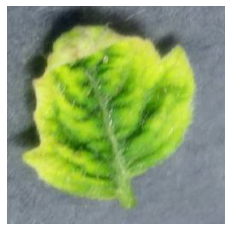

Actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


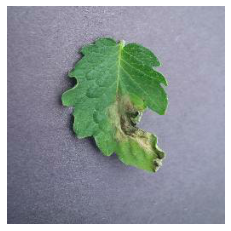

Actual label: Tomato___Late_blight
Predicted label: Tomato___Late_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 100.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


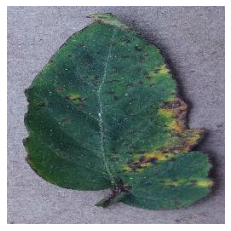

Actual label: Tomato___Bacterial_spot
Predicted label: Tomato___Bacterial_spot
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 100.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


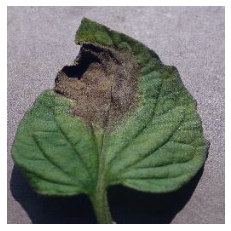

Actual label: Tomato___Late_blight
Predicted label: Tomato___Late_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 100.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


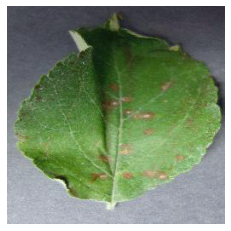

Actual label: Apple___Cedar_apple_rust
Predicted label: Apple___Cedar_apple_rust
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 100.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


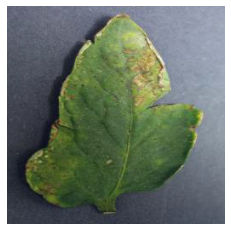

Actual label: Tomato___Bacterial_spot
Predicted label: Tomato___Bacterial_spot
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 100.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


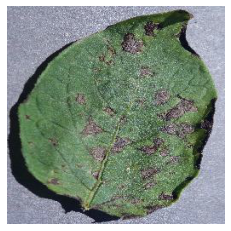

Actual label: Potato___Early_blight
Predicted label: Potato___Early_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 100.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


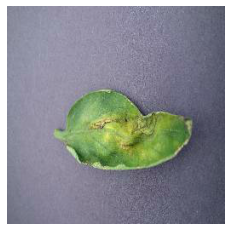

Actual label: Tomato___Late_blight
Predicted label: Tomato___Late_blight
Confidence scores:
Apple___Apple_scab: 0.19%
Apple___Cedar_apple_rust: 0.54%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.58%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.01%
Potato___Late_blight: 0.36%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 1.52%
Tomato___Early_blight: 0.07%
Tomato___Late_blight: 96.68%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.04%

Image to predict:


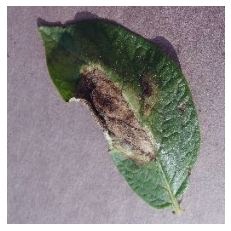

Actual label: Potato___Late_blight
Predicted label: Potato___Late_blight
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 100.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


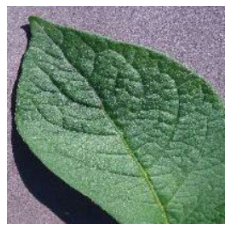

Actual label: Potato___healthy
Predicted label: Potato___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 100.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%

Image to predict:


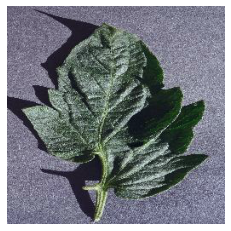

Actual label: Tomato___healthy
Predicted label: Tomato___healthy
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 0.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 100.00%

Image to predict:


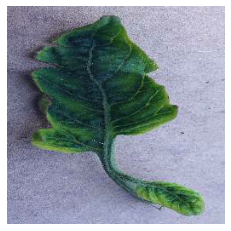

Actual label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Predicted label: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Confidence scores:
Apple___Apple_scab: 0.00%
Apple___Cedar_apple_rust: 0.00%
Apple___healthy: 0.00%
Pepper,_bell___Bacterial_spot: 0.00%
Pepper,_bell___healthy: 0.00%
Potato___Early_blight: 0.00%
Potato___Late_blight: 0.00%
Potato___healthy: 0.00%
Tomato___Bacterial_spot: 0.00%
Tomato___Early_blight: 0.00%
Tomato___Late_blight: 0.00%
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 100.00%
Tomato___Tomato_mosaic_virus: 0.00%
Tomato___healthy: 0.00%



In [48]:
def predict_with_confidence(data_loader, model_alex, class_names, device):
    model_alex.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        images_processed = 0
        for images_batch, labels_batch in data_loader:
            images_batch = images_batch.to(device)  # Move input tensors to the correct device
            labels_batch = labels_batch.to(device)  # Move input tensors to the correct device

            for i in range(len(images_batch)):
                image = images_batch[i].permute(1, 2, 0).cpu().numpy()  # Move image to CPU and convert to numpy array
                image = (image - image.min()) / (image.max() - image.min())  # Normalize the image

                label = labels_batch[i].item()

                print("Image to predict:")
                plt.imshow(image)
                plt.axis('off')
                plt.show()
                print("Actual label:", class_names[label])

                outputs = model_alex(images_batch[i].unsqueeze(0))  # Add batch dimension
                _, predicted = torch.max(outputs, 1)
                confidence = torch.nn.functional.softmax(outputs, dim=1)[0]  # Calculate confidence scores
                predicted_label = predicted.item()

                print("Predicted label:", class_names[predicted_label])
                print("Confidence scores:")
                for class_idx, class_name in enumerate(class_names):
                    print(f"{class_name}: {confidence[class_idx].item() * 100:.2f}%")
                print()

                images_processed += 1
                if images_processed >= 12:
                    break
            if images_processed >= 12:
                break

# Example usage
predict_with_confidence(test_loader, model_alex, class_names, device)


In [71]:
# Specify the path where you want to save the model
model_path = "model_alex.pth"

# Save the model's state dictionary
torch.save(model_alex.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to model_alex.pth


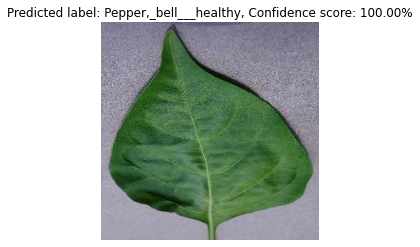

In [70]:
def predict_single_image(image, model_alex, class_names, device):
    model_alex.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Preprocess the image
        preprocess = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(image)
        input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Predict the label and confidence score
        outputs = model_alex(input_tensor)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0]  # Calculate confidence scores
        predicted_label = torch.argmax(confidence).item()

        # Display the image with the predicted label and confidence score
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted label: {class_names[predicted_label]}, Confidence score: {confidence[predicted_label].item() * 100:.2f}%")
        plt.show()

# Example usage
image = Image.open('image\image (51).JPG')
predict_single_image(image, model_alex, class_names, device)


# GOOGLE NET

In [33]:
# Load the pre-trained GoogleNet model
model_gnet = models.googlenet(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_gnet = model_gnet.to(device)

In [34]:
model_gnet.fc = nn.Linear(model_gnet.fc.in_features, num_classes).to(device)


In [35]:
# Move the model's parameters to the same device
model_gnet_parameters = model_gnet.state_dict()
for parameter_name in model_gnet_parameters:
    model_gnet_parameters[parameter_name] = model_gnet_parameters[parameter_name].to(device)
model_gnet.load_state_dict(model_gnet_parameters)

<All keys matched successfully>

In [36]:
# Define loss function and optimizer
criterion_gnet = nn.CrossEntropyLoss().cuda()
optimizer_gnet = optim.Adam(model_gnet.parameters(), lr=0.001)

In [37]:
def calculate_accuracy(model_gnet,loader):
    model_gnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_gnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



In [38]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model_gnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_gnet.zero_grad()
        outputs = model_gnet(inputs)
        loss = criterion_gnet(outputs, labels)
        loss.backward()
        optimizer_gnet.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    
    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(model_gnet,val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Training Accuracy: {epoch_accuracy}, Validation Accuracy: {val_accuracy}")


Epoch 1/2, Loss: 0.2373841244932754, Training Accuracy: 0.9256432004523607, Validation Accuracy: 0.9343891402714932
Epoch 2/2, Loss: 0.09355707376298003, Training Accuracy: 0.9705400056545095, Validation Accuracy: 0.9579185520361991


In [39]:
# Evaluate on validation set
val_accuracy = calculate_accuracy(model_gnet,val_loader)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on test set
test_accuracy = calculate_accuracy(model_gnet,test_loader)
print(f"Test Accuracy: {test_accuracy}")


Validation Accuracy: 0.9579185520361991
Test Accuracy: 0.9556962025316456


# RESNET50

In [69]:
model_resnet = models.resnet50(pretrained=True)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes)
model_resnet = model_resnet.to(device)


In [70]:
criterion_resnet = nn.CrossEntropyLoss().cuda()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.001, betas=(0.9, 0.999))



In [74]:
def calculate_accuracy(model_resnet,loader):
    model_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [75]:


for epoch in range(EPOCHS):
    model_resnet.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    
    model_resnet.eval()
    val_accuracy = calculate_accuracy(model_resnet, val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Training Accuracy: {epoch_accuracy}, Validation Accuracy: {val_accuracy}")


KeyboardInterrupt: 

# ENSEMBLE(GNET,ALEXNET)

In [11]:
# Initialize the models
google_net = models.googlenet(pretrained=True).cuda()  # Move to GPU
alex_net = models.alexnet(pretrained=True).cuda()  # Move to GPU

In [12]:
# Freeze the parameters in both models
for param in google_net.parameters():
    param.requires_grad = False
for param in alex_net.parameters():
    param.requires_grad = False

In [13]:
# Modify the output layers to match the number of classes in your dataset
google_net.fc = nn.Linear(google_net.fc.in_features, num_classes).cuda()  # Move to GPU
alex_net.classifier[6] = nn.Linear(alex_net.classifier[6].in_features, num_classes).cuda()  # Move to GPU

In [15]:
class EnsembleModel1(nn.Module):
    def __init__(self, google_net, alex_net, num_classes):
        super(EnsembleModel1, self).__init__()
        self.google_net = google_net.cuda()  # Move to GPU
        self.alex_net = alex_net.cuda()  # Move to GPU
        # Modify the output sizes to match the concatenation of features
        self.google_net.fc = nn.Linear(self.google_net.fc.in_features, num_classes).cuda()
        self.alex_net.classifier[6] = nn.Linear(self.alex_net.classifier[6].in_features, num_classes).cuda()
        # Concatenate the features from both models
        self.fc = nn.Linear(self.google_net.fc.out_features + self.alex_net.classifier[6].out_features, num_classes).cuda()

    def forward(self, x):
        google_features = self.google_net(x)
        alex_features = self.alex_net(x)
        assert google_features.size(0) == alex_features.size(0), "Batch sizes do not match"
        assert google_features.size(1) == self.google_net.fc.out_features
        assert alex_features.size(1) == self.alex_net.classifier[6].out_features
        features = torch.cat((google_features, alex_features), dim=1)
        return self.fc(features)


In [16]:
# Initialize the ensemble model
ensemble_model1 = EnsembleModel1(google_net, alex_net, num_classes)

In [17]:
ensemble_model1=ensemble_model1.cuda()

In [18]:
criterion_en = nn.CrossEntropyLoss().cuda()
optimizer_en = torch.optim.Adam(ensemble_model1.parameters(), lr=0.001)

In [19]:
def calculate_accuracy(loader, ensemble_model1):
    ensemble_model1.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = ensemble_model1(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [21]:
# Train the model
for epoch in range(EPOCHS):
    ensemble_model1.train()
    total_train_correct = 0
    total_train_samples = 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()  # Move to GPU
        optimizer_en.zero_grad()
        outputs = ensemble_model1(images)
        loss = criterion_en(outputs, labels)
        loss.backward()
        optimizer_en.step()
        _, predicted = torch.max(outputs, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels).sum().item()
    train_accuracy = total_train_correct / total_train_samples * 100

    # Validate the model
    ensemble_model1.eval()
    val_accuracy = calculate_accuracy(val_loader, ensemble_model1)
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/30, Training Accuracy: 95.65%, Validation Accuracy: 0.96%
Epoch 2/30, Training Accuracy: 96.61%, Validation Accuracy: 0.97%
Epoch 3/30, Training Accuracy: 97.21%, Validation Accuracy: 0.97%
Epoch 4/30, Training Accuracy: 97.53%, Validation Accuracy: 0.96%
Epoch 5/30, Training Accuracy: 97.72%, Validation Accuracy: 0.97%
Epoch 6/30, Training Accuracy: 97.98%, Validation Accuracy: 0.98%
Epoch 7/30, Training Accuracy: 98.08%, Validation Accuracy: 0.97%
Epoch 8/30, Training Accuracy: 98.08%, Validation Accuracy: 0.97%
Epoch 9/30, Training Accuracy: 98.22%, Validation Accuracy: 0.98%
Epoch 10/30, Training Accuracy: 98.28%, Validation Accuracy: 0.97%
Epoch 11/30, Training Accuracy: 98.34%, Validation Accuracy: 0.98%
Epoch 12/30, Training Accuracy: 98.30%, Validation Accuracy: 0.98%
Epoch 13/30, Training Accuracy: 98.59%, Validation Accuracy: 0.98%
Epoch 14/30, Training Accuracy: 98.35%, Validation Accuracy: 0.98%
Epoch 15/30, Training Accuracy: 98.53%, Validation Accuracy: 0.98%
Epoc

In [22]:
# Evaluate on validation set
val_accuracy = calculate_accuracy(val_loader, ensemble_model1)
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate on test set
test_accuracy = calculate_accuracy(test_loader, ensemble_model1)
print(f"Test Accuracy: {test_accuracy}")

Validation Accuracy: 0.9796380090497737
Test Accuracy: 0.9814647377938517


# ENSEMBLE(GNET & CNN)

In [24]:


class CustomCNN(nn.Module):
    def __init__(self, num_classes=14):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1).cuda()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1).cuda()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1).cuda()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512).cuda()
        self.fc2 = nn.Linear(512, 256).cuda()
        self.fc3 = nn.Linear(256, num_classes).cuda()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x






    

In [25]:
# Load a pre-trained GoogleNet model
google_net = models.googlenet(pretrained=True).cuda()
google_net.fc = nn.Linear(google_net.fc.in_features, 2).cuda()  # Assuming 14 classes

In [26]:
class EnsembleModel2(nn.Module):
    def __init__(self, cnn_model, googlenet_model):
        super(EnsembleModel2, self).__init__()
        self.cnn_model = cnn_model.cuda()
        self.googlenet_model = googlenet_model.cuda()

    def forward(self, x):
        x = x.cuda()
        cnn_output = self.cnn_model(x)
        googlenet_output = self.googlenet_model(x)

        combined_output = torch.cat((cnn_output, googlenet_output), dim=1)
        return combined_output






In [27]:
cnn_model = CustomCNN().cuda()
ensemble_model2 = EnsembleModel2(cnn_model, google_net)


In [28]:
ensemble_model2= ensemble_model2.cuda()

In [29]:
criterion_en2 = nn.CrossEntropyLoss().cuda()
optimizer_en2 = optim.Adam(ensemble_model2.parameters(), lr=0.001)


In [30]:
for epoch in range(30):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    ensemble_model2.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer_en2.zero_grad()
        outputs = ensemble_model2(inputs)
        loss = criterion_en2(outputs, labels)
        loss.backward()
        optimizer_en2.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    
    ensemble_model2.eval()  # Set model to evaluation mode
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = ensemble_model2(images)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    total_test = 0
    correct_test = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = ensemble_model2(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test

    print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Test Accuracy: {test_accuracy}")


C:\Users\sinha\anaconda3\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 